In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
from functools import cmp_to_key

plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)
plt.subplots(figsize=(15,10))

%matplotlib inline

In [2]:
DATA_DIR = '/home/ryan/cs/datasets/microsoft'

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
len(dtypes)

83

In [5]:
%time train = pd.read_csv(join(DATA_DIR, 'train.csv'), dtype=dtypes)
%time test = pd.read_csv(join(DATA_DIR, 'test.csv'), dtype=dtypes)

CPU times: user 1min 20s, sys: 2.05 s, total: 1min 22s
Wall time: 1min 22s
CPU times: user 1min 8s, sys: 1.48 s, total: 1min 9s
Wall time: 1min 9s


In [6]:
osver_path = '/home/ryan/cs/datasets/microsoft/OSVersionTimestamps.npy'
avsig_path = '/home/ryan/cs/datasets/microsoft/AvSigVersionTimestamps.npy'

In [6]:
# good_cols = list(train.columns)
# for col in train.columns:
#     rate = train[col].isnull().sum() / len(train)
#     if rate > 0.9:
#         print(col)
#         good_cols.remove(col)

In [7]:
train['Census_DeviceFamily'].head()

0    Windows.Desktop
1    Windows.Desktop
2    Windows.Desktop
3    Windows.Desktop
4    Windows.Desktop
Name: Census_DeviceFamily, dtype: category
Categories (3, object): [Windows.Desktop, Windows.Server, Windows]

In [8]:
def group_battery(x):
    x = x.lower()
    if ('li' in x) or ('ion' in x):
        return 1
    else:
        return 0
    
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [8]:
for i, feat in enumerate(train.columns):
    

    percent = train[feat].value_counts(normalize=True, dropna=False).values[0]
    if percent >= 0.95:
        print(feat)
        print(percent)

ProductName
0.989355693442
IsBeta
0.999992490038
RtpStateBitfield
0.969736421624
IsSxsPassiveMode
0.982666222645
DefaultBrowsersIdentifier
0.951416373264
AVProductsEnabled
0.970029422238
HasTpm
0.987971058175
Platform
0.966063041313
OsVer
0.967613232015
AutoSampleOptIn
0.999971081041
PuaMode
0.999741186527
Firewall
0.968562513654
UacLuaenable
0.992718026812
Census_DeviceFamily
0.998382555905
Census_ProcessorClass
0.995894068284
Census_IsPortableOperatingSystem
0.999454799163
Census_IsFlightsDisabled
0.981997275565
Census_IsVirtualDevice
0.991184985725
Census_IsPenCapable
0.96192908735


In [8]:

for i, feat in enumerate(train.columns):
    print(i)
    print(feat)
    print(train[feat].nunique())
    print(train[feat].isnull().sum()/train.shape[0])
    print(train[feat].value_counts(normalize=True, dropna=False).values[0])
    print(train[feat].dtype)
    print(train[feat].head())
    print(train[feat].unique())
    print()

0
MachineIdentifier
8921483
0.0
1.12088987896e-07
category
0    0000028988387b115f69f31a3bf04f09
1    000007535c3f730efa9ea0b7ef1bd645
2    000007905a28d863f6d0d597892cd692
3    00000b11598a75ea8ba1beea8459149f
4    000014a5f00daa18e76b81417eeb99fc
Name: MachineIdentifier, dtype: category
Categories (8921483, object): [0000028988387b115f69f31a3bf04f09, 000007535c3f730efa9ea0b7ef1bd645, 000007905a28d863f6d0d597892cd692, 00000b11598a75ea8ba1beea8459149f, ..., ffffef606490b2970873ec0a27ebd24b, fffff8a40070d2d8379bb7fa2ed2fa66, fffffbbaaf5969ae4b93e7f3f6d7132f, ffffff75ba4f33d938ccfdb148b8ea16]
[0000028988387b115f69f31a3bf04f09, 000007535c3f730efa9ea0b7ef1bd645, 000007905a28d863f6d0d597892cd692, 00000b11598a75ea8ba1beea8459149f, 000014a5f00daa18e76b81417eeb99fc, ..., ffffedfe8fcc46e6d36ab39953589fee, ffffef606490b2970873ec0a27ebd24b, fffff8a40070d2d8379bb7fa2ed2fa66, fffffbbaaf5969ae4b93e7f3f6d7132f, ffffff75ba4f33d938ccfdb148b8ea16]
Length: 8921483
Categories (8921483, object): [000002898

0.234779912712
int8
0    -85
1     64
2     49
3    115
4     75
Name: LocaleEnglishNameIdentifier, dtype: int8
[ -85   64   49  115   75  124   88  -84 -122  107  -74   74   71   70   42
   58   46   10  -42   -5  -23   60  -86  -38  118  -35  -28   17   52   69
   83  106  103  -29   12   56   68  -30  -45  -46  -40   21  126  -39   72
   91   16  -26    8   55  113  -32   51   34  -88  -27  -37    7   22   93
  -17   15  -33    6  -34  -21  -10   32  -31  -20  102  -94   -3   77 -117
  -25   73  105   97   80  -24  -41 -116   94   81   66    5   96  -54   13
   19   44   67 -127   36  -80    9   45   61   63   65   27  -77  -22  125
 -124  -78   14  116   79   76   35  -57  -58  114   82  101    2  121   26
 -121  -18   59   95  -96   90   43 -102   92 -109  -19   11  -97  -47 -113
   78  -56   24 -112    4   85  -64 -107   50  -55  100    1  -44  104  -48
   33    3 -114   30  -90   87   62 -104   -4   89   20   -9  -98  108   41
  -87  -93 -120   54  117   40   25  -69  -75  -76  

[NaN, RequireAdmin, ExistsNotSet, Off, Warn, ..., prompt, warn, 00000000, requireAdmin, &#x03;]
Length: 22
Categories (21, object): [RequireAdmin, ExistsNotSet, Off, Warn, ..., warn, 00000000, requireAdmin, &#x03;]

32
Firewall
2
0.0102393290443
0.968562513654
float16
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Firewall, dtype: float16
[  1.   0.  nan]

33
UacLuaenable
11
0.00121482045082
0.992718026812
float32
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: UacLuaenable, dtype: float32
[  1.00000000e+00   0.00000000e+00              nan   4.80000000e+01
   3.00000000e+00   2.00000000e+00   6.35706200e+06   4.90000000e+01
   1.67772160e+07   5.00000000e+00   2.55000000e+02   7.79888400e+06]

34
Census_MDC2FormFactor
13
0.0
0.641521034115
category
0     Desktop
1    Notebook
2     Desktop
3     Desktop
4    Notebook
Name: Census_MDC2FormFactor, dtype: category
Categories (13, object): [AllInOne, Convertible, Desktop, Detachable, ..., SmallServer, SmallTablet, ServerOther, IoTO

2050
0.00526661318527
0.506088954045
float16
0    1440.0
1    1366.0
2    1920.0
3    1366.0
4    1366.0
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: float16
[ 1440.  1366.  1920. ...,  2920.  2900.   978.]

50
Census_InternalPrimaryDisplayResolutionVertical
1552
0.00526661318527
0.557488144068
float16
0     900.0
1     768.0
2    1080.0
3     768.0
4     768.0
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: float16
[  900.   768.  1080. ...,  2858.  2106.  1229.]

51
Census_PowerPlatformRoleName
10
6.16489433427e-06
0.693035899973
category
0    Desktop
1     Mobile
2    Desktop
3    Desktop
4     Mobile
Name: Census_PowerPlatformRoleName, dtype: category
Categories (10, object): [AppliancePC, Desktop, EnterpriseServer, Mobile, ..., UNKNOWN, Workstation, PerformanceServer, Unspecified]
[Desktop, Mobile, Slate, Workstation, SOHOServer, ..., AppliancePC, EnterpriseServer, PerformanceServer, NaN, Unspecified]
Length: 11
Categories (10, object): [Desktop, M

0.356360259836
float16
0    26.0
1     8.0
2     7.0
3    17.0
4     8.0
Name: Census_OSInstallLanguageIdentifier, dtype: float16
[ 26.   8.   7.  17.  18.  14.  27.   6.  29.  37.  39.  10.  35.   9.  20.
  25.  nan   1.   4.   5.  24.  31.  30.  19.  15.   3.   2.  16.  33.  23.
  36.  22.  12.  13.  32.  21.  38.  28.  34.  11.]

63
Census_OSUILocaleIdentifier
147
0.0
0.355414452956
int16
0    119
1     31
2     30
3     64
4     31
Name: Census_OSUILocaleIdentifier, dtype: int16
[119  31  30  64  72  49 120  28 125 158 160  35 148  34  83 115   5  24
 156  26 109 130 128  74  58  20  11  62 140 105 151  92  44  48 136  17
  90 159 161 123 145  42  68  38  54  12  32  59  63  37 143 111  15  27
  51  36 116  93  65  21   7 122 121  29  50   6 106 126  76 141 135 110
  70  82  80  85 162  91 157 149  95  60 124  69   9 131 132  71 117  73
 152  40  84 146 112  57  19 142  39  98  75 134 129 144 108  13  67 139
  66  45 133  46  33  22 150  96  77  87  25  14  52 153  41   1   3 138
 

0.0179491458987
0.0179491458987
float32
0    36144.0
1    57858.0
2    52682.0
3    20050.0
4    19844.0
Name: Census_FirmwareVersionIdentifier, dtype: float32
[ 36144.  57858.  52682. ...,   3871.  33818.  69704.]

74
Census_IsSecureBootEnabled
2
0.0
0.513977104479
int8
0    0
1    0
2    0
3    0
4    0
Name: Census_IsSecureBootEnabled, dtype: int8
[0 1]

75
Census_IsWIMBootEnabled
2
0.634390381061
0.634390381061
float16
0    NaN
1    NaN
2    NaN
3    NaN
4    0.0
Name: Census_IsWIMBootEnabled, dtype: float16
[ nan   0.   1.]

76
Census_IsVirtualDevice
2
0.0017881556239
0.991184985725
float16
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Census_IsVirtualDevice, dtype: float16
[  0.  nan   1.]

77
Census_IsTouchEnabled
2
0.0
0.874456858798
int8
0    0
1    0
2    0
3    0
4    0
Name: Census_IsTouchEnabled, dtype: int8
[0 1]

78
Census_IsPenCapable
2
0.0
0.96192908735
int8
0    0
1    0
2    0
3    0
4    0
Name: Census_IsPenCapable, dtype: int8
[0 1]

79
Census_IsAlwaysOnAlways

In [9]:
# train = train[good_cols]

In [29]:
def generate_version_mapping(df, col, num_splits=4, fill_val='0.0.0.0'):
    feature = df[col].astype(str)
    feature.fillna(fill_val)
    versions = feature.unique()
    
    def version_compare(x, y):
        x_splits = x.split('.')
        y_splits = y.split('.')
        for x_val, y_val in zip(x_splits, y_splits):
            try:
                int_x = int(x_val)
            except:
                int_x = 0
            try:
                int_y = int(y_val)
            except:
                int_y = 0
            if int_x > int_y:
                return 1
            elif int_x < int_y:
                return -1
        return 0

    sorted_versions = sorted(versions, key=cmp_to_key(version_compare))
    mapping = {}
    for i, v in enumerate(sorted_versions):
        mapping[v] = i
        
    return feature.map(mapping)

In [30]:
train['AvSigVersion'].unique()

[1.273.1735.0, 1.263.48.0, 1.273.1341.0, 1.273.1527.0, 1.273.1379.0, ..., 1.213.6073.0, 1.217.500.0, 1.213.1918.0, 1.203.1966.0, 1.223.1075.0]
Length: 8531
Categories (8531, object): [1.273.1735.0, 1.263.48.0, 1.273.1341.0, 1.273.1527.0, ..., 1.217.500.0, 1.213.1918.0, 1.203.1966.0, 1.223.1075.0]

In [31]:
generate_version_mapping(train, 'AvSigVersion')

0          7997
1          6036
2          7887
3          7929
4          7896
5          7832
6          7797
7          7898
8          8331
9          7819
10         7806
11         8008
12         7894
13         8294
14         7814
15         8042
16         8092
17         7703
18         8524
19         8003
20         7787
21         7680
22         8157
23         8058
24         8288
25         8035
26         7895
27         8520
28         8017
29         7935
           ... 
8921453    8378
8921454    8245
8921455    8492
8921456    7682
8921457    8487
8921458    8501
8921459    2456
8921460    8419
8921461    7696
8921462    7752
8921463    7939
8921464    7865
8921465    8368
8921466    7624
8921467    6822
8921468    8177
8921469    8389
8921470    7790
8921471    7806
8921472    8373
8921473    8147
8921474    8439
8921475    7481
8921476    8134
8921477    7951
8921478    7933
8921479    2453
8921480    8377
8921481    7267
8921482    8373
Name: AvSigVersion, Leng

In [10]:
columns_to_examine = ['ProductName', 'IsBeta', 'RtpStateBitfield', 
                      'IsSxsPassiveMode', 'AVProductsInstalled', 'AVProductsEnabled']

In [11]:
columns_to_examine2 = ['HasTpm', 'Platform', 'Processor', 'OsSuite', 
                       'OsPlatformSubRelease', 'SkuEdition',
                       'IsProtected', 'AutoSampleOptIn', 'SMode']

In [12]:
columns_to_examine3 = ['SmartScreen', 'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor',
                       'Census_DeviceFamily', 'Census_ProcessorCoreCount', 'Census_ProcessorModelIdentifier',
                       ]

In [13]:
columns_to_examine4 = ['Census_PrimaryDiskTypeName', 'Census_HasOpticalDiskDrive',
                       'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSArchitecture',
                       'Census_OSBranch', 'Census_OSInstallTypeName', 'Census_OSInstallLanguageIdentifier',
                       'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel']
                       

In [14]:
columns_to_examine5 = ['Census_FlightRing', 'Census_IsSecureBootEnabled', 'Census_IsTouchEnabled',
                       'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer',
                       'Wdft_RegionIdentifier']

In [8]:
def plot_categorical_freq(df, col, on='HasDetections'):
    categories = list(df[col].unique())
    groups = df.groupby(col)
    sizes = groups.size()
    sums = groups.sum()[on]
    ratios = sums / sizes   
    print(ratios)
    plt.subplots(figsize=(10,5))
    plt.title('Ratio of {} by {}'.format(on, col))
    ax = sns.barplot(x=ratios.index, y=ratios.values)
    plt.show()
    print(sizes)
    plt.subplots(figsize=(10,5))
    plt.title('Counts of {}'.format(col))
    ax = sns.barplot(x=sizes.index, y=sizes.values)
    plt.show()

SkuEdition
Cloud              0.383432
Education          0.526982
Enterprise         0.516721
Enterprise LTSB    0.522655
Home               0.492266
Invalid            0.467625
Pro                0.513226
Server             0.274149
dtype: float64


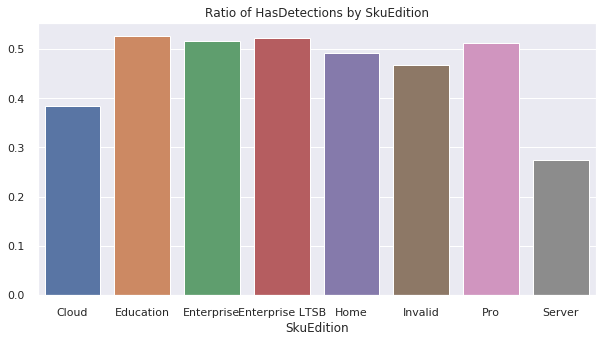

SkuEdition
Cloud                 5589
Education            40694
Enterprise           34357
Enterprise LTSB      20702
Home               5514341
Invalid              78054
Pro                3224164
Server                3582
dtype: int64


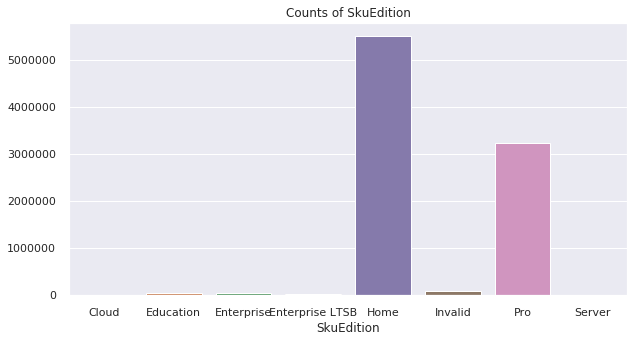

In [10]:
plot_categorical_freq(train, 'SkuEdition')

In [11]:
sku_df = train[['SkuEdition', 'Census_OSSkuName']]

In [12]:
sku_df

,SkuEdition,Census_OSSkuName
0,Pro,PROFESSIONAL
1,Pro,PROFESSIONAL
2,Home,CORE
3,Pro,PROFESSIONAL
4,Home,CORE
5,Pro,PROFESSIONAL
6,Home,CORE
7,Home,CORE
8,Pro,PROFESSIONAL
9,Home,CORE_SINGLELANGUAGE


In [17]:
train['LocaleEnglishNameIdentifier'].head()

0    -85
1     64
2     49
3    115
4     75
Name: LocaleEnglishNameIdentifier, dtype: int8

In [18]:
# for col in columns_to_examine5:
#     plot_categorical_freq(train, col)

In [19]:
train['AVProductsInstalled'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: AVProductsInstalled, dtype: float16

In [20]:
new_train = pd.DataFrame()

In [21]:
def condense_feature(df, col, category_map, fill_with=None):
    feature = df[col]
    reverse_map = {}
    default_val = None
    categories = feature.unique()
    categories = categories[~pd.isnull(categories)]
    
    for k, v_arr in category_map.items():
        if len(v_arr) != 0:
            for v in v_arr:       
                reverse_map[v] = k
                index = np.argwhere(categories==v)
                categories = np.delete(categories, index)         
        else:
            default_val = k
            
    for v in categories:
        reverse_map[v] = default_val
        
    condensed = df[col].map(reverse_map)
    if fill_with:
        condensed = condensed.fillna(fill_with)
    else:
        condensed = condensed.fillna(default_val)
    
    return condensed

In [22]:
def generate_count_feature(df, col):
    feature = df[col]
    groups = df.groupby(col)
    sizes = groups.size()
    count_feature = df[col].map(sizes)
    
    return count_feature

In [23]:
def generate_freq_feature(df, col, on='HasDetections'):
    feature = df[col]
    groups = df.groupby(col)
    sizes = groups.size()
    sums = groups.sum()[on]
    ratios = sums/sizes
    freq_feature = df[col].map(ratios)
    
    return freq_feature

In [24]:
train['SkuEdition'].unique()

[Pro, Home, Invalid, Enterprise LTSB, Enterprise, Education, Cloud, Server]
Categories (8, object): [Pro, Home, Invalid, Enterprise LTSB, Enterprise, Education, Cloud, Server]

In [25]:
new_train['MoreThanOneAV'] = condense_feature(train, 'AVProductsInstalled', {0: [0.0, 1.0], 1: []}, fill_with=0)

In [26]:
new_train['AVProductsEnabled'] = train['AVProductsEnabled'].fillna(0.0).astype(np.int8)

In [27]:
new_train['PlatformCounts'] = generate_count_feature(train, 'Platform')

In [28]:
new_train = new_train.join(pd.get_dummies(train['Processor']))

In [29]:
new_train = new_train.join(pd.get_dummies(train['OsPlatformSubRelease']))

In [30]:
sku_feature = condense_feature(train, 'SkuEdition', {'Home': ['Home'], 'Pro': ['Pro'], 'SkuEtc':[]})
new_train = new_train.join(pd.get_dummies(sku_feature))

In [31]:
new_train['IsProtected'] = train['IsProtected'].astype(np.bool)

In [32]:
new_train['SmartScreen'] = condense_feature(train, 'SmartScreen', 
                                            {True: ['RequireAdmin', 'On', 'Warn', 'on', 'Enabled', 'warn', 'Block', 'Prompt', 'Promp', 'requireadmin', 'prompt', 'requireAdmin'], 
                                             False: []}).astype(np.bool)

In [33]:
new_train.head()

,MoreThanOneAV,AVProductsEnabled,PlatformCounts,arm64,x64,x86,prers5,rs1,rs2,rs3,rs4,th1,th2,windows7,windows8.1,Home,Pro,SkuEtc,IsProtected,SmartScreen
0,0.0,1,8618715,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,True,False
1,0.0,1,8618715,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,True,False
2,0.0,1,8618715,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,True,True
3,0.0,1,8618715,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,True,False
4,0.0,1,8618715,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,True,True


In [34]:
from numba import jit
# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# idea from this kernel: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred


def train_model(X=train, X_test=test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature = cat_cols)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                    feval=eval_auc)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            # print('predicting on test')
            # y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = predict_chunk(model, X_test)
            # print('predicted')
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            y_pred = predict_chunk(model, xgb.DMatrix(X_test))
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='roc_auc', cv=3)
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
            
        scores.append(fast_auc(y_valid, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            logging.info('Top features')
            for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
                logging.info(f)

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

NameError: name 'test' is not defined

In [ ]:
result_dict1 = train_model(X=train1, X_test=test, y=y1, params=params, model_type='lgb', plot_feature_importance=True, averaging='rank')

In [ ]:
# def generate_version_mapping(df, col, num_splits=4, fill_val='0.0.0.0'):
#     # create a map from version to ordinal value
    
    
#     feature = df[col].astype(str)
#     feature.fillna(fill_val)
#     versions = feature.unique()
#     splits = [x.split('.') for x in versions]
    
#     mappings = []
#     multipliers = []
#     for s in range(num_splits):
#         vals = sorted(list(set([int(x[s]) for x in splits])))
#         multipliers.append(len(vals))
#         mapping = {}
#         for i, v in enumerate(vals):
#             mapping[v] = i
#         mappings.append(mapping)
            

#     for m in range(num_splits-2, -1, -1):
#         multipliers[m] *= multipliers[m+1]
        
# #     for i, mapping in enumerate(mappings):
# #         for k, v in mapping.items():
# #             mapping[k] = v*multipliers[i]

#     print(multipliers)
#     def apply_mapping(version):
#         split = version.split('.')
#         h_val = 0
#         for i, s in enumerate(split):
#             h_val += mappings[i][int(s)] *multipliers[i]
#         return h_val
            
#     v_feature = df[col].apply(apply_mapping)
#     indices = np.argsort(v_feature)
#     print(indices)
#     return v_feature